# Lab 4 Simulating Nature at Utility Scale

In this lab we will explore utility scale work by simulating the dynamics of a large Heisenberg spin chain. The goal is to measure the dynamics of $Z_i$ for a given site as a function of time and external field $h$ for two different phases of the spin chain.

This lab will be broken into sections matching the Qiskit Patterns framework which include the following steps:

1. Map the system to quantum circuits and operators
2. Optimize the circuits to be executed
3. Execute the time evolution circuits
4. Analyze or post-process the results

### Introduction
The Heisenberg model, introduced in the late 1920s, is a popular model used to study magnetic phenomena and phase transitions in many-body systems. It is related to its more simplified cousin, the Ising model, and examines the dynamics that emerge from what is known as the *exchange interaction*. This interaction arises from a combination of the Pauli exclusion principle and the Coulomb interaction [[1]](https://doi.org/10.1119/1.4798343) and has a Hamiltonian of the form:

$$ H = \sum_{i=1}^N\left(J_x X_iX_{i+1} + J_y Y_iY_{i+1} + J_z Z_iZ_{i+1}\right). $$

Here $N$ is the number of sites in our chain and $X_i$, $Y_i$, and $Z_i$ are the Pauli operators which act on the $i^{th}$ site. The parameters $J_x$, $J_y$, and $J_z$, represent the coupling strength for the Coulomb ($J_x$ and $J_y$) and Ising ($J_z$) interaction. For the rest of the lab we'll consider $J_x=J_y=1$ for simplicity.

In general this model has a few phases based on the ratio $\Delta = J_z/J$ (also known as the anisotropy). In this lab we will explore two of them:
- The **istropic** phase where $\Delta = 1$. This is also known as the **XXX** phase.
- The **anisotropic** phase when $\Delta \neq 1$.

To measure some interesting dynamics of this system, we will also introduce a transverse magnetic field with a strength $h$ which will interact with each site through the Pauli $X$ operator. The Hamiltonian of our spin chain will now take the form:

\begin{align}
H =& \sum_{i=1}^N\left(J X_iX_{i+1} + J Y_iY_{i+1} + J_z Z_iZ_{i+1} + hX_i\right) \\
    =& \sum_{i=1}^N\left(X_iX_{i+1} + Y_iY_{i+1} + \Delta Z_iZ_{i+1} + hX_i\right)
\end{align}

where we have substituted $\Delta = J_z/J$.

## Step 0: Setup

The code cells below will install all the required packages needed for this lab, you will also set your API token as an environment variable which the grader will need to save your progress.

In [103]:
!pip install qiskit[visualization]==1.1.0
# Use the following if you are on MacOS/zsh
#!pip install 'qiskit[visualization]'==1.1.0
!pip install qiskit_ibm_runtime
!pip install matplotlib
!pip install pylatexenc
!pip install networkx
!pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /tmp/pip-req-build-x5bkkde_
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-req-build-x5bkkde_
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit bcaff898473fd54f3e2668f162817947787f7268
  Preparing metadata (setup.py) ... done


In [1]:
### Save API Token, if needed
%set_env QXToken=#ADD_PERSONAL_API_KEY

# Make sure there is no space between the equal sign
# and the beginning of your token
# Make sure you do NOT ADD QUOTATION MARKS!!!!

env: QXToken=#ADD_PERSONAL_API_KEY


## Step 1: Map the system to quantum circuits and operators


In this lab we will examine the dynamics of the expectation value $\langle Z_i \rangle$ averaged over each site as a function of the field strength $h$. In the experiments below, you will prepare a circuit which implements the time evolution operator acting on the state $|000...0\rangle$ according to the system parameters. For simplicity we will should set $\delta t = \frac{\pi}{4}$. This ensures that $\theta_J = -2J_z\delta t = -\frac{\pi}{2}$ which makes the time evolution of our system much simpler for the isotropic phase.

In this first exercise, you will create a function to generate the Hamiltonian in the form of a `SparsePauliOp` object. We'll introduce the modules you'll need, define some system parameters, and demonstrate a quick example of how you might want to accomplish this task.

In [2]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.synthesis import LieTrotter

from qiskit_ibm_runtime.options import EstimatorOptions, DynamicalDecouplingOptions
from qiskit_ibm_runtime import EstimatorV2, Batch

import numpy as np
import matplotlib.pyplot as plt
import json

We'll first begin by defining the parameters for our system. This includes the number of sites, anisotropy $\Delta$, external field $h$, and evolution time $\delta t$.

In [106]:
# Define system parameters

num_spins = 12
anisotropy = 1.
h = 1.
dt = Parameter('δt')

Next we can define our chain using some of the built-in methods of the `CouplingMap` object. Let's use the `from_ring()` method to create a system with periodic boundary conditions.

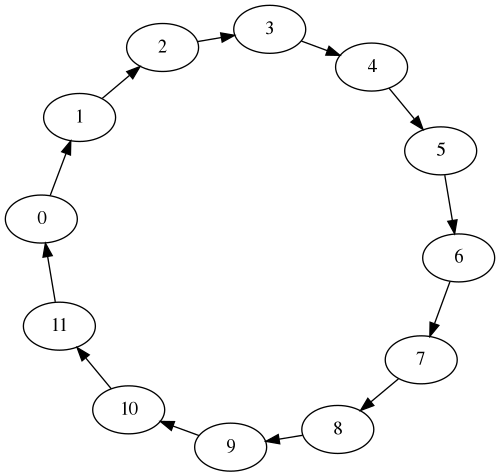

In [107]:
lattice_map = CouplingMap.from_ring(num_spins, bidirectional=False)
lattice_map.draw()

With our lattice defined, we'll next create our Hamiltonian using the `PauliOp.from_sparse_list()` method. This function takes in a list of 3-tuples containing information about the operator, qubit index, and coefficient. To create this list we'll iterate over each edge in our lattice map.

In [108]:
edgelist = lattice_map.graph.edge_list()
hamlist = []

for edge in edgelist:
    hamlist.append(("XX", edge, 1.))
    hamlist.append(("YY", edge, 1.))
    hamlist.append(("ZZ", edge, anisotropy))

for qubit in lattice_map.physical_qubits:
    hamlist.append(("X", [qubit], h))

hamiltonian = SparsePauliOp.from_sparse_list(hamlist, num_qubits=num_spins)
print(hamiltonian)

SparsePauliOp(['IIIIIIIIIIXX', 'IIIIIIIIIIYY', 'IIIIIIIIIIZZ', 'IIIIIIIIIXXI', 'IIIIIIIIIYYI', 'IIIIIIIIIZZI', 'IIIIIIIIXXII', 'IIIIIIIIYYII', 'IIIIIIIIZZII', 'IIIIIIIXXIII', 'IIIIIIIYYIII', 'IIIIIIIZZIII', 'IIIIIIXXIIII', 'IIIIIIYYIIII', 'IIIIIIZZIIII', 'IIIIIXXIIIII', 'IIIIIYYIIIII', 'IIIIIZZIIIII', 'IIIIXXIIIIII', 'IIIIYYIIIIII', 'IIIIZZIIIIII', 'IIIXXIIIIIII', 'IIIYYIIIIIII', 'IIIZZIIIIIII', 'IIXXIIIIIIII', 'IIYYIIIIIIII', 'IIZZIIIIIIII', 'IXXIIIIIIIII', 'IYYIIIIIIIII', 'IZZIIIIIIIII', 'XXIIIIIIIIII', 'YYIIIIIIIIII', 'ZZIIIIIIIIII', 'XIIIIIIIIIIX', 'YIIIIIIIIIIY', 'ZIIIIIIIIIIZ', 'IIIIIIIIIIIX', 'IIIIIIIIIIXI', 'IIIIIIIIIXII', 'IIIIIIIIXIII', 'IIIIIIIXIIII', 'IIIIIIXIIIII', 'IIIIIXIIIIII', 'IIIIXIIIIIII', 'IIIXIIIIIIII', 'IIXIIIIIIIII', 'IXIIIIIIIIII', 'XIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 

### Exercise 1. Write a function to generate a Hamiltonian

In this first exercise you'll create a function to build a Hamiltonian for a system with **closed** boundary conditions which takes the system parameters and system size as arguments.

*Hint: To create a coupling map with closed boundary conditions, use the [`CouplingMap.from_line()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.CouplingMap#from_line) method.*

In [109]:
# Exercise 1: Create a function that will correctly generate the Hamiltonian for a Heisenberg chain given either


def build_hamiltonian(num_spins, anisotropy, h):

    ### Your code goes here ###
    line_map=CouplingMap.from_line(num_spins, bidirectional=False)
    edgelist = line_map.graph.edge_list()
    hamlist = []

    for edge in edgelist:
        hamlist.append(("XX", edge, 1.))
        hamlist.append(("YY", edge, 1.))
        hamlist.append(("ZZ", edge, anisotropy))

    for qubit in line_map.physical_qubits:
            hamlist.append(("X", [qubit], h))

    hamiltonian = SparsePauliOp.from_sparse_list(hamlist, num_qubits=num_spins)
    return hamiltonian



In [110]:
# Submit answer to exercise 1
from qc_grader.challenges.qgss_2024 import grade_lab4_ex1

grade_lab4_ex1(build_hamiltonian)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Generate the time evolution circuit

Now that we have the ability to quickly define a Hamiltonian, we next need to consider how to generate the time evolution operator and execute it using a `QuantumCircuit` object. First, recall that the time evolution operator of a static Hamiltonian has the form:

\begin{align}
    U(t) =& e^{-iHt},
\end{align}

and if we plug in the Hamiltonian of *our* system, the time evolution operator then appears as
$$ U(t) = \exp\left(-it\sum_{i=1}^NX_iX_{i+1} + Y_iY_{i+1} + \Delta Z_iZ_{i+1} + hX_i\right) $$

Next we need to consider how to decompose this into a linear combination of gates which can be executed using a quantum computer. In general, the time evolution operator must be approximated and, conveniently, the Qiskit SDK has some built-in functionality to assist us in generating this. We will use the `PauliEvolutionGate` object and `LieTrotter` synthesis class to use the Li-Trotter approximation for $U(t)$.

The code below accomplishes a few steps to help understand the workflow:
1. Generate the `SparsePauliOp` from the function you created above.
2. Create a `PauliEvolutionGate` representing the action of $U(t)$ for the Hamiltonian and specified time parameter.
3. Instantiate a new `LieTrotter` object in order to synthesize the approximated time evolution.
4. Apply the `synthesize()` mtehod on the `PauliEvolutionGate` defined and draw the resulting circuit

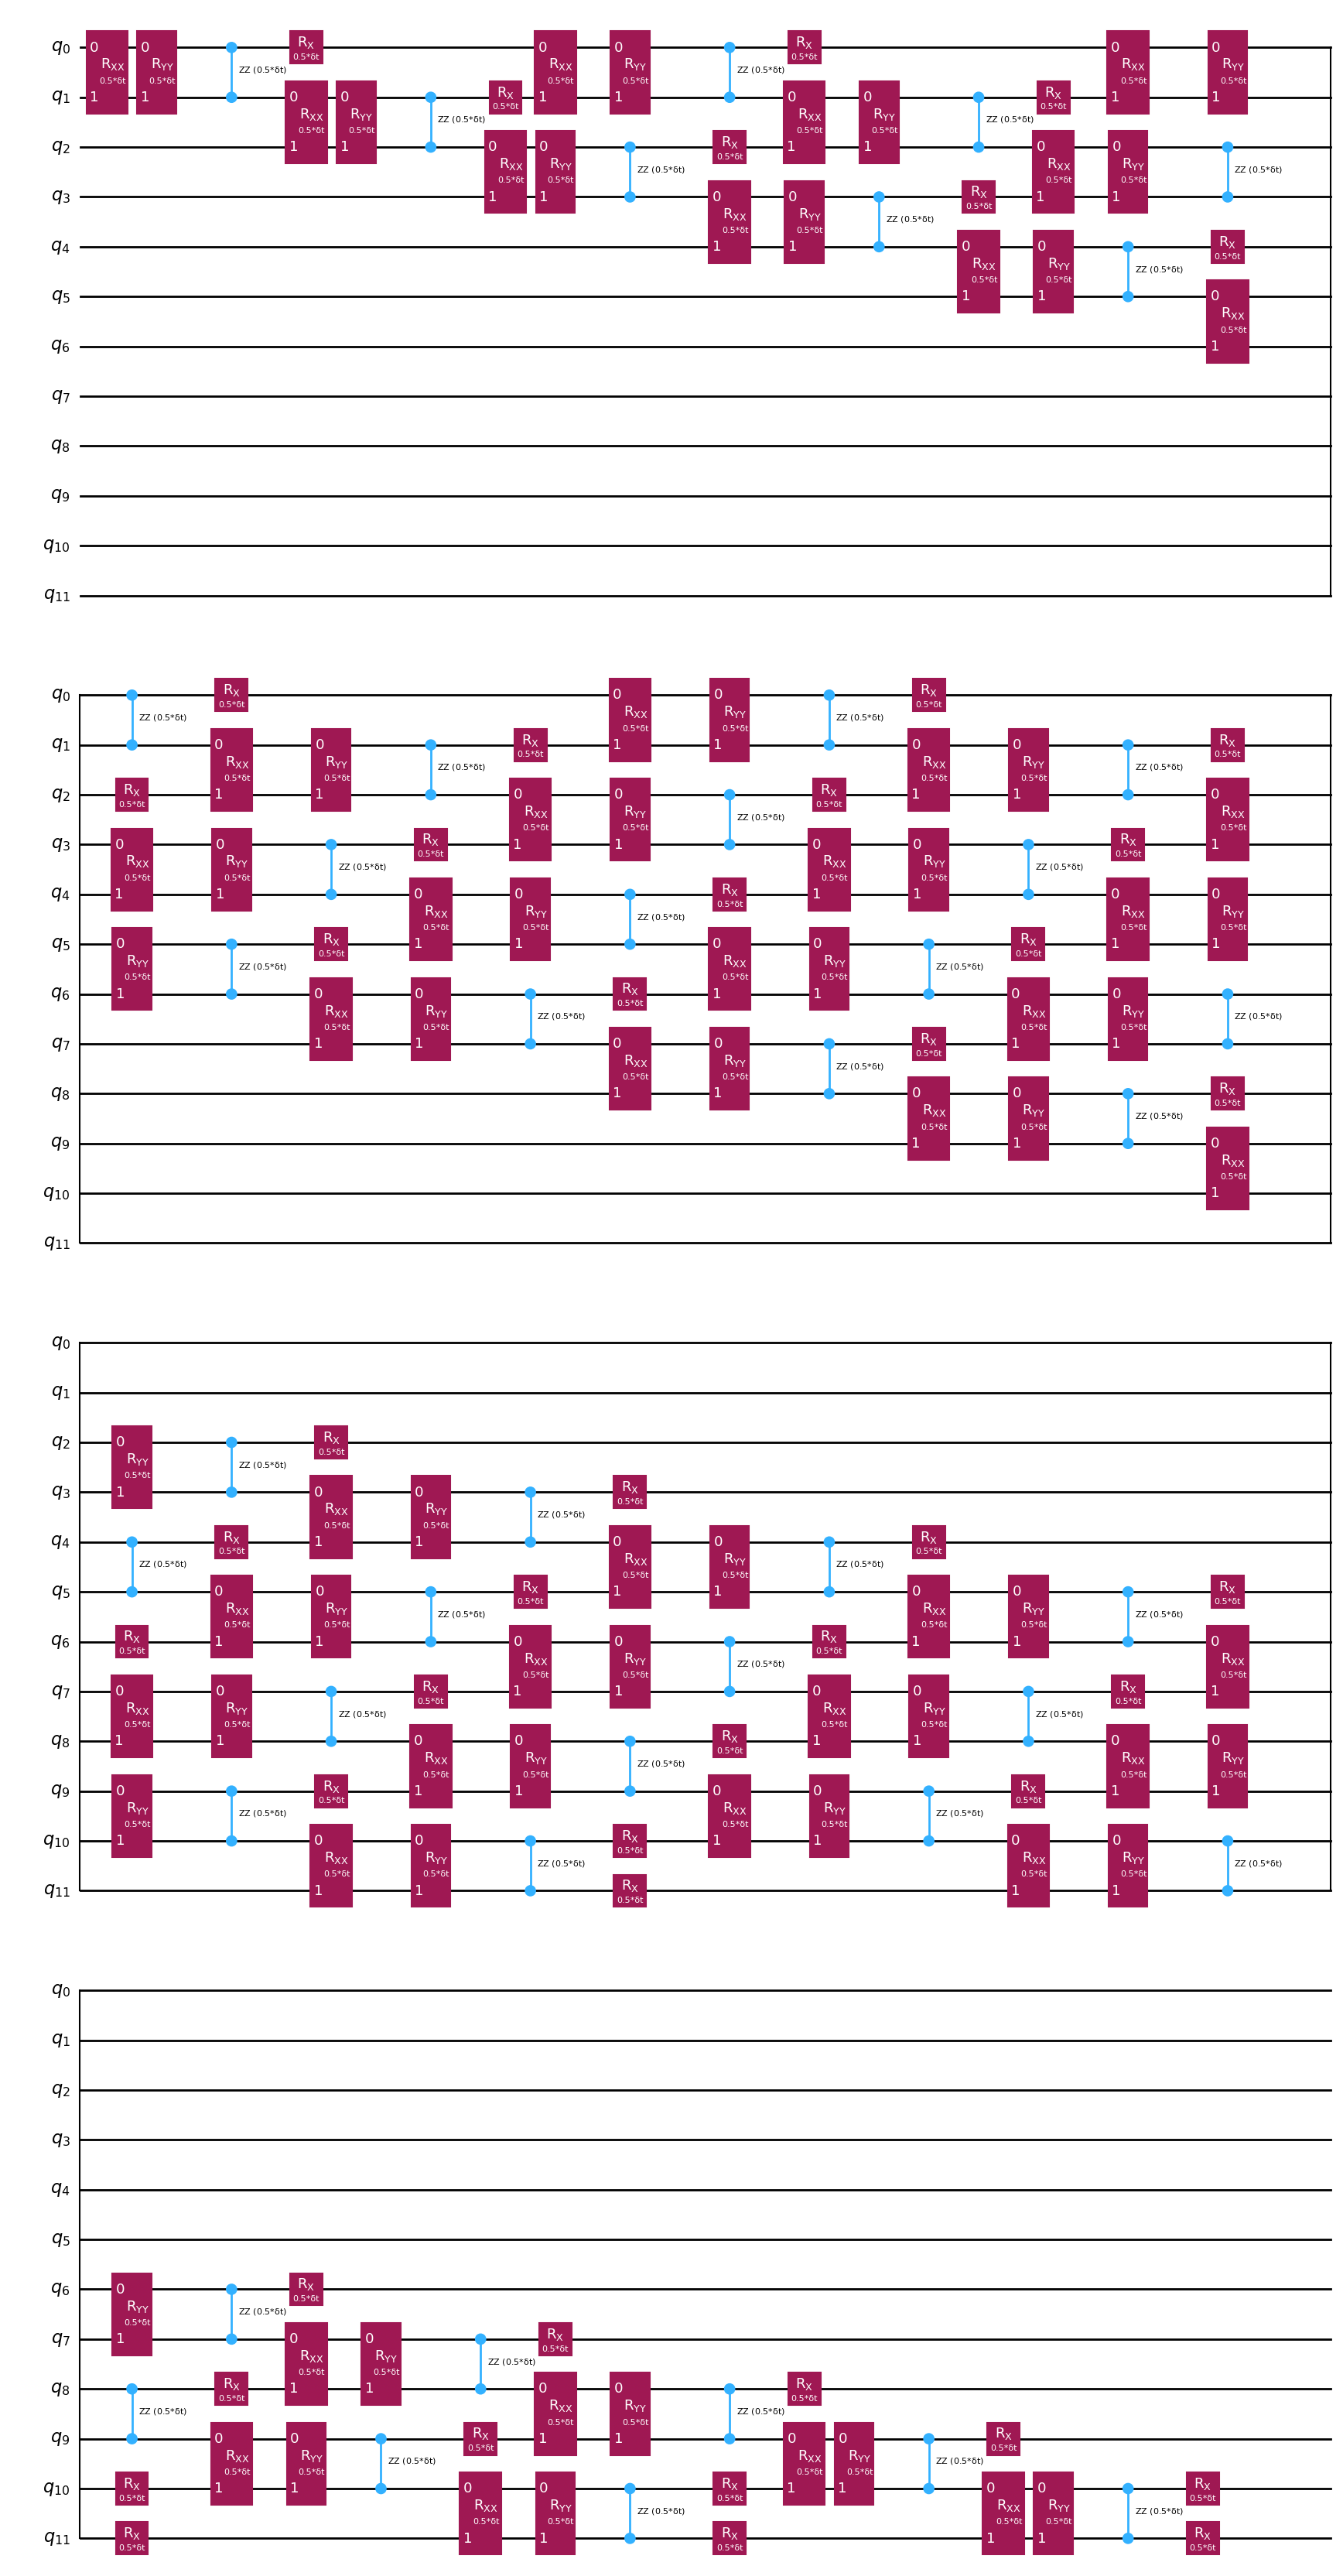

In [111]:
# Prepare a time evolution circuit
hamiltonian = build_hamiltonian(num_spins, anisotropy, h)
time_evolution_operator = PauliEvolutionGate(hamiltonian, time=dt)
trotter_factory = LieTrotter(reps=4)
evolution_circuit = trotter_factory.synthesize(time_evolution_operator)
evolution_circuit.decompose().draw('mpl')

### Define Observables for Expectation Value Measurement

Lastly we need to define the expectation values we wish to measure using the `EstimatorV2` primitive. Recall that in this lab we will measure the average magnetization $M_Z = \frac{1}{N}\sum_i \langle Z_i \rangle$ as a function of the external field strength, $h$.

To do this we'll need to define a list of operators which correspond to each measurement of $\langle Z_i \rangle$. For this, the [`SparsePauliOp.from_sparse_list()`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp#from_sparse_list) function is again quite handy.


In [112]:
z_observables = [ SparsePauliOp.from_sparse_list([('Z', [i], 1.)], num_qubits=num_spins) for i in range(num_spins) ]
print(z_observables)

[SparsePauliOp(['IIIIIIIIIIIZ'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIIZI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIIZII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIIZIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIZIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIZIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIZIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIZIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIZIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IZIIIIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['ZIIIIIIIIIII'],
              coeffs=[1.+0.j])]


## Step 2: Optimize your circuits

Now that we have a way to generate the time evolution circuits, we should consider how we can optimize them in order to minimize the amount of noise we will observe when running on real hardware.

### Exercise 2. Refactor time evolution operators into entangling layers

Upon examining the time evolution circuits that are generated using the `LieTrotter` or `SuzukiTrotter` synthesis functions, you may notice that they produce a sequence of gates which leave the qubits idle for long periods of time. To optimize the execution of these circuits, we can reorder the two-qubit rotations into two entangling layers acting on even and odd pairs of qubits. An example of what a single layer of this circuit looks like is shown below:


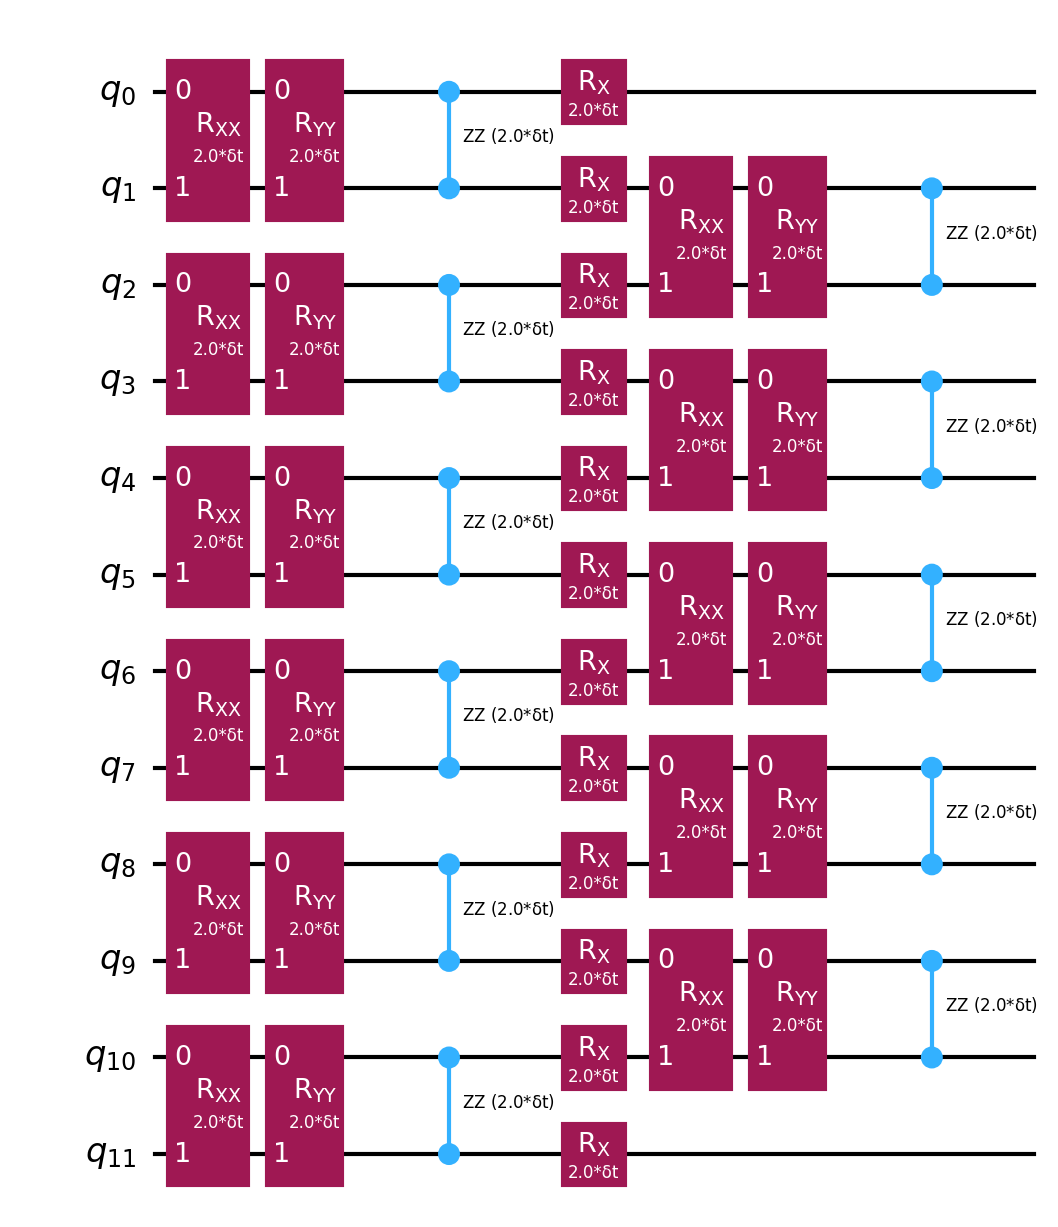

In this next exercise, create a new function called `build_layered_hamiltonian` which will create a `SparsePauliOp` objects which is a sum of operators acting on even pairs of qubits and odd pairs of qubits. do so

*(Hint: follow the same steps as before, but include a check to see if you are inspecting an even or odd qubit pair when iterating over the graph.)*

In [113]:
# Exercise 2: Create a function that will generate a reordered Hamiltonian which is more efficient for qpu execution.

def build_layered_hamiltonian(num_spins, anisotropy, h):

    ### Your code goes here ###
    line_map=CouplingMap.from_line(num_spins, bidirectional=False)
    edgelist = line_map.graph.edge_list()
    hamlist_ev = []
    hamlist_odd=[]
    for edge in edgelist:
        if edge[0]%2==0:
            hamlist_ev.append(("XX", edge, 1.))
            hamlist_ev.append(("YY", edge, 1.))
            hamlist_ev.append(("ZZ", edge, anisotropy))
        else:
            hamlist_odd.append(("XX", edge, 1.))
            hamlist_odd.append(("YY", edge, 1.))
            hamlist_odd.append(("ZZ", edge, anisotropy))
    for qubit in line_map.physical_qubits:
        if edge[0]%2==0:
            hamlist_ev.append(("X", [qubit], h))
        else:
            hamlist_odd.append(("X", [qubit], h))
    hamiltonian_ev = SparsePauliOp.from_sparse_list(hamlist_ev, num_qubits=num_spins)

    hamiltonian_odd = SparsePauliOp.from_sparse_list(hamlist_odd, num_qubits=num_spins)
    return hamiltonian_ev+hamiltonian_odd





In [114]:
# Submit answer to exercise 2
from qc_grader.challenges.qgss_2024 import grade_lab4_ex2

grade_lab4_ex2(build_layered_hamiltonian)



Submitting your answer. Please wait...


Congratulations 🎉! Your answer is correct and has been submitted.


### Exercise 3. Transpile your circuit

Now that the time evolution circuit has been optimized, we'll next prepare it for execution on quantum hardware. For this exercise, build a staged passmanager and transpile the time evolution circuit using the backend obtained from the following code cell. Once you've obtained a layout for the circuit, apply it to the observables we created above using the `apply_layout()` method.

*Note: You'll need to select a backend using a `QiskitRuntimeService()` object and use if for the pass manager.*

In [115]:
# Your code goes here

backend = QiskitRuntimeService().backend("ibm_sherbrooke")
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
# Run the pass manager on `evolution_circuit` and name the variable `isa_circuit`
isa_circuit =pass_manager.run(evolution_circuit)
isa_z_obs=[z_observables[i].apply_layout(isa_circuit.layout) for i in range(len(z_observables))]

In [116]:
# Submit answer to exercise 3
from qc_grader.challenges.qgss_2024 import grade_lab4_ex3

grade_lab4_ex3(
    backend,
    isa_circuit,
    isa_z_obs
)



Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 3: Execute on a backend

Now we'll put our transpiled circuit together alongside the operators we have defined. We will prepare a set of circuits to run in a `Batch` where we will measure $Z$ as a function of the external field $h$.

First we will instantiate a set of error mitigation options for the estimator primitive:

In [117]:
dd_options = DynamicalDecouplingOptions(enable=True, sequence_type="XpXm")
options = EstimatorOptions(dynamical_decoupling=dd_options)
options.resilience.zne_mitigation = True
options

max_execution_time,Unset
default_precision,Unset
default_shots,Unset
optimization_level,Unset
resilience_level,Unset
seed_estimator,Unset
experimental,Unset
▸environment,EnvironmentOptions
log_level,'WARNING'
callback,None
job_tags,None


### Exercise 4. Prepare the circuits to execute

Below a set of system parameters has been provided for you to perform your time evolution experiment. You will simulate the time evolution of a 50-site Heisenberg chain and measure the expectation value $\langle Z\rangle$ of each site. You'll need to create a set of circuits to accomplish this for the two different phases specified in the `anisotropies` dict defined below. These two phases to simulate are the *Anisotropic* phase ($\Delta = -5$) and the *XXX* phase ($\Delta = 1$). Also recall that we will use $\delta t = 5\pi/4$ in order for the $ZZ$ gates to rotate by $-\pi/2$.

To complete this exercise, you'll need to create several dictionaries containing the Hamiltonians, time evolution operators, transpiled time evolution circuits, and the observables to measure. The lab will assume that each of these dictionaries has two keys: `Anisotropic` and `XXX` and that the value associated with each key will store a list containing elements of the associated data type.

The following dictionaries to create are:
1. A dictionary of hamiltonians built using the `build_layered_hamiltonian` function you created earlier for each value of external field $h$ specified in the variable `h_vals`. The list for each key should contain the Hamiltonians for each value from the $h_{vals}$ list.
  - The format of this data structure should be `Dict{ key_corresponding_to_phase : List_over_hvals[ SparsePauliOp ]}`
3. A dictionary containing lists of time evolution operators generated from the Hamiltonians you created in the previous step.
  - The format of this data structure should be: `Dict{ key_corresponding_to_phase : List_over_hvals[ PauliEvolutionGate ]}`
4. A dictionary containing lists of quantum circuits synthesized using the `LieTrotter.synthesize()` method, passing in the time evolution operators defined above as well as the `Parameter` value, `dt`.
  - The format of this data structure should be: `Dict{ key_corresponding_to_phase : List_over_hvals[ QuantumCircuit ]}`
5. A dictionary containing lists of the transpiled circuits
  - The format of this data structure should be: `Dict{ key_corresponding_to_phase : List_over_hvals[ QuantumCircuit ]}`
6. A dictionary containing lists of `SparsePauliOp` operators to use as the set of observables to measure.
   - The format of this data structure should be:
   - `Dict{ key_corresponding_to_phase : List_over_hvals[ List_over_sites [ SparsePauliOp ] ]}`


In [118]:

# Exercise 4: Create the set of transpiled time evolution circuits and observables for each
#  of the phases and values of h to investigate.
# Hint: list comprehension will make this much simpler to approach

dt = Parameter('δt')
dt_val = [5*np.pi/2.]
h_vals = np.linspace(0., np.pi/2, 12)
anisotropies = {"Anisotropic":-5., "XXX":1}
num_spins = 50
z_observables = [ SparsePauliOp.from_sparse_list([('Z', [i], 1.)], num_qubits=num_spins) for i in range(num_spins) ]
# Dictionaries to use for exercise submission
hamiltonians = {}
time_evolution_operators = {}
trotter_circuits = {}
isa_circuits = {}
isa_z_observables = {}

# Loop over each phase of the heisenberg system
for phase, anisotropy in anisotropies.items():
    # For each anisotropy value you'll need to loop over all values from h_vals

    hlist = [build_layered_hamiltonian(num_spins, anisotropy,h)  for h in h_vals]
    hamiltonians[phase] = hlist
    time_evolution_operators[phase] = [PauliEvolutionGate(ham, time=dt) for ham in hlist]
    trotter_circuits[phase] = [trotter_factory.synthesize(teo) for teo in time_evolution_operators[phase]]
    isa_circuits[phase] = [pass_manager.run(tc) for tc in trotter_circuits[phase]]
    isa_z_observables[phase] = [[z_observables[i].apply_layout(circ.layout) for i in range(0,num_spins)] for circ in isa_circuits[phase]]
        # At each value of h, you'll need to
            # 1. Generate the associated hamiltonian
            # 2. Create the time evolution operator
            # 3. Generate the time evolution circuit
            # 4. Transpile the circuit
            # 5. Apply the layout of the transpiled circuit to the observables




In [119]:
# Submit answer to exercise 4
from qc_grader.challenges.qgss_2024 import grade_lab4_ex4

grade_lab4_ex4(hamiltonians,
              time_evolution_operators,
              isa_circuits,
              isa_z_observables)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Exercise 5. Build the PUBs to execute on hardware

Now that the circuits to execute and observables to measure have been prepared, we'll next need to create the Primitive Unified Blocs (PUBs) in order to submit these jobs to quantum hardware. Each PUB is a tuple containing the circuit to execute in the first element, a list of observables to measure in the second, and a list of parameter values to set (in our case this is $\delta t$.) You can read more about the format of PUBs in the [documentation](https://docs.quantum.ibm.com/run/primitives#interface-changes).

In [120]:
# Now build the pubs to execute
# Exercise 5: Build to pubs to execute these circuits

all_z_obs_pubs = {}

for phase, circuits in isa_circuits.items():
    all_z_obs_pubs[phase]=[]
    observables=isa_z_observables[phase]
    for circuit, observ in zip(circuits,observables):
        pub=(circuit,observ, dt_val)
        all_z_obs_pubs[phase].append(pub)
isa_circuit.depth()

539

In [121]:
for phase, pubs in all_z_obs_pubs.items():
    for i, pub in enumerate(pubs):
        depth = pub[0].depth()
        if depth > 300:
            print(phase,i,depth,"depth better be < 300")
        for op,cnt in pub[0].count_ops().items():
            if op == 'rz' and cnt > 5420:
                print(phase,i,depth,op,cnt)
            if op == 'sx' and cnt > 2570:
                print(phase,i,depth,op,cnt)
            if op == 'ecr' and cnt > 1000:
                print(phase,i,depth,op,cnt)
            if op == 'x' and cnt > 100:
                print(phase,i,depth,op,cnt)

In [27]:
# Submit answer to exercise 5
from qc_grader.challenges.qgss_2024 import grade_lab4_ex5

grade_lab4_ex5(all_z_obs_pubs)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Exercise 6: Use the `Batch` execution mode to execute your circuits

Since the circuits we will run do not depend on one another, we can submit these to the backend using the `Batch` execution mode. Here you will submit each circuit as its own job within the Batch context and save the associated job id to a dictionary to be stored as a JSON file for later parsing.

To accomplish this, we suggest iterating over the list of pubs for each phase and submitting each pub individually.

---
**IMPORTANT NOTE: THESE JOBS WILL REQUIRE 6 MINUTES OF QPU TIME**

    If you do not have enough available time on your account to run these jobs, uncomment the line just before the grader submission to set the file name variable to "skip-question".



In [21]:
# Exercise 6: Use the `Batch` context to run your circuits
all_z_obs_jobs = {}

with Batch(backend=backend) as batch:
    # Print information about the session
    print(f"Session ID: {batch.session_id}")
    print(f"Backend: {batch.backend()}")
    # Instantiate an estimator primitive
    estimator = EstimatorV2(session=batch, options=options)
    # Run your jobs here and save the job ids to the dictionary `all_z_obs_jobs`. We suggest
    #  you do so by iterating over each phase and storing the associated list of ids.
    for phase in all_z_obs_pubs.keys():
        all_z_obs_jobs[phase] = []
        for pub in all_z_obs_pubs.values():
            job = estimator.run(pub)
            all_z_obs_jobs[phase].append(job.job_id()) 

Session ID: ctjntw3x7b5g008zz0a0
Backend: ibm_sherbrooke


In [22]:
all_z_obs_jobs

{'Anisotropic': ['ctjntx3907y0008vqq40', 'ctjntyb4gjh0008ny2bg'],
 'XXX': ['ctjntzbsj17g0081f840', 'ctjnv0m907y0008vqq50']}

Once these jobs are submitted, you'll then want to save the job ids to a file so that you can retrieve the data once they are complete.

In [23]:
# Store job ids into a dictionary and save them as a json file

fname = "jobrun.json"
with open(fname, 'w') as file:
   json.dump(all_z_obs_jobs, file)

In [122]:
# Submit the dict as an answer
from qc_grader.challenges.qgss_2024 import grade_lab4_ex6

# Uncomment the below line if you were unable to run this on hardware
#fname = "skip-question"

grade_lab4_ex6(fname)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 4: Post-Process

In these last two exercises you will retrieve and post-process your results.

### Exercise 7: Retrieve your job results
For this exercise you'll use the `service.job(job_id)` method in order to retrieve your jobs by job id. You can obtain these ids either from the dictionary you defined earlier or by loading the json file which you saved them to. The lab assumes that the data you retrieve will be in the form of a dictionary whose keys associate with each phase you simulated and corresponding values contain a list of the job data.




In [24]:
# Code to grab all of the expectation values
# Exercise 7: Parse all the data
service = QiskitRuntimeService()
all_job_data = {}
def retrieve_job_data(job_ids):
    job_data = []
    for job_id in job_ids:
        try:
            # Retrieve job data using the service.job method
            job_info = service.job(job_id)
            job_data.append(job_info.result())
        except Exception as e:
            print(f"Error retrieving job {job_id}: {e}")
    return job_data
fname="jobrun.json"
with open('jobrun.json','r') as json_File :
    data_load=json.load(json_File)
for phase,job_id in data_load.items():
    all_job_data[phase]=retrieve_job_data(job_id)
    

In [20]:
print(all_job_data)

{'Anisotropic': [<RuntimeJobV2('ctjntx3907y0008vqq40', 'estimator')>, <RuntimeJobV2('ctjntyb4gjh0008ny2bg', 'estimator')>], 'XXX': [<RuntimeJobV2('ctjntzbsj17g0081f840', 'estimator')>, <RuntimeJobV2('ctjnv0m907y0008vqq50', 'estimator')>]}


**NOTE: If you were unable to run your jobs, uncomment the below lines to obtain the pre-baked results**

In [27]:
# Submit answer to exercise 7
from qc_grader.challenges.qgss_2024 import grade_lab4_ex7

# Uncomment these lines to load the pre-baked results in case you were unable to run the jobs
#from qc_grader.challenges.qgss_2024 import lab4_ex7_get_data
#all_job_data = lab4_ex7_get_data()


grade_lab4_ex7(all_job_data)

AttributeError: 'RuntimeJobV2' object has no attribute 'results'

### Exercise: 8 Compute and plot your results

In this final exercise, you will use the `PrimitiveResult` data and obtain the average $\langle Z_i \rangle$ over each site as a function of the field strength $h$. Once the averages have been obtained, store them in a dictionary called `avg_z_data` whose keys correspond to each phase. Finally, plot this data using a tool such as matplotlib to view the results side by side.

In [28]:
# Your code goes here
avg_z_data = {}
for phase, results in all_job_data.items():
    avg_z_data[phase]=[]
    for data in results:
        z_values = data[0].data.evs
        avg_z_data[phase].append(np.mean(z_values))

In [125]:
# Submit answer to exercise 7
from qc_grader.challenges.qgss_2024 import grade_lab4_ex8

grade_lab4_ex8({'Anisotropic':avg_z_data['Anisotropic'],
                'XXX':avg_z_data['XXX']})

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


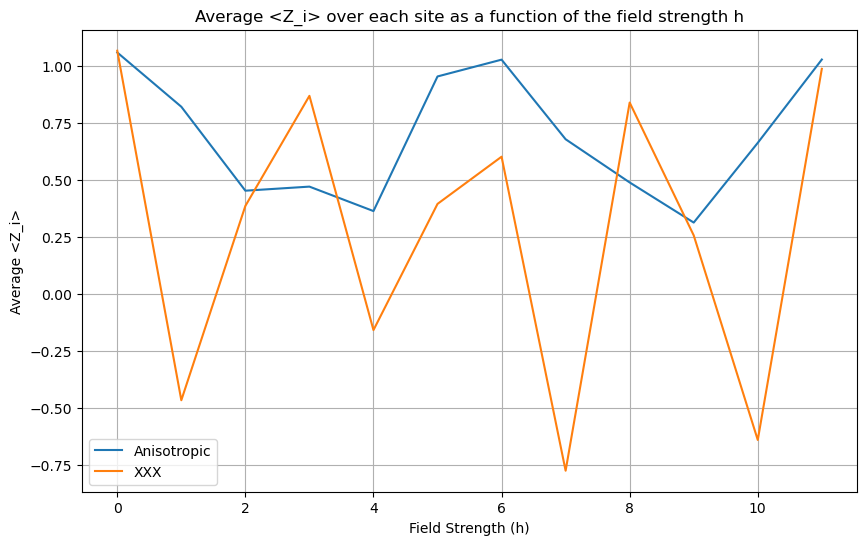

In [29]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

for phase, avg_z_list in avg_z_data.items():
    plt.plot(avg_z_list, label=phase)

plt.xlabel('Field Strength (h)')
plt.ylabel('Average <Z_i>')
plt.title('Average <Z_i> over each site as a function of the field strength h')
plt.legend()
plt.grid(True)
plt.show()


In [126]:
import datetime
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()